# Simple pipeline

A simple pipeline to ilustrate ML concepts

Let's import some libraries

In [49]:
import pandas as pd #Data manipulation
import numpy as np #Linear algebra
import matplotlib.pyplot as plt #Visualization
import seaborn as sns
sns.set_style("whitegrid") #Just set some styles
#Machine learning models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats.distributions import uniform, norm #Probability distributions
from sklearn.model_selection import cross_validate

We wil create our function to adjust
$$
  f(x) = sin(2 \pi x)
$$
Our goal is to exploit this training set in order to make predictions of the value f(x) for some new value x of the input variable. -> Generalization

This is hard because we have a finite dataset! And also we have an error term that simulates the noise in data!



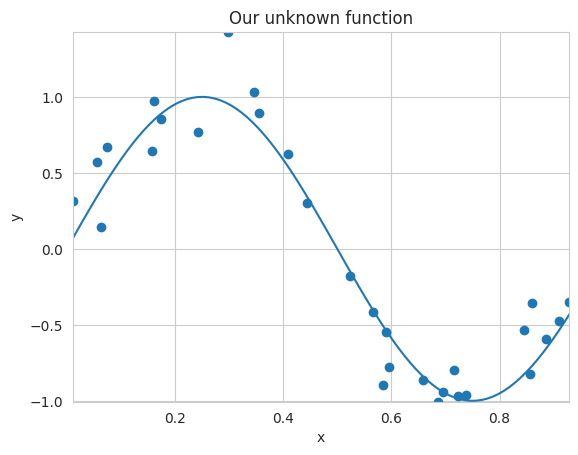

In [50]:
N = 30 # We will draw 50 points uniformly distributed
x = uniform.rvs(0, 1,size=N)
e = norm.rvs(0, 0.2, size = N) #An error variable following a gaussian distribution
y = np.sin(2* np.pi*x) + e #We will create a function f(x) = 2 sin(x) - 0.5 x + e

x_line = np.linspace(0,1,100) #We will draw the line using a linear space of 100 points
y_line = np.sin(2*np.pi*x_line) #And we draw the same function as y

#Let's plot
plt.ylim(y.min(),y.max())
plt.xlim(x.min(),x.max())
plt.scatter(x, y)
plt.title("Our unknown function")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x_line, y_line)

x = x.reshape(-1,1) #We will reshape X in order to use a matrix of values

We will fill the data using a polynomial function

$$
  y(x,w) = w_0 + w_1 x + w_2 x² + ... + w_M x^M = \sum_j^M w_j x^j
$$


Where M is the order of the polynomial

Where w are the polynomial coefficients

We can fit the polynomial to the training data minimizing an error function that measures the misfit between the function y(x,w) for any given value of w, and the training set data points.

A simple error function is Least-squares error

$$
  E(w) = \frac{1}2 \sum_n^N \{y(x_n, w) - t_n\} ^2
$$

Just follow me with this

In [51]:
def get_poly(degree, x, y): #This function just creates a polynomial model and adjust it to the present data
    pf = PolynomialFeatures(degree=degree).fit(x) #We assign polynomial features and train using X
    lr = LinearRegression() #We train the linear model with order 'degree'
    pipe = Pipeline(
            [
                ("polynomial_features", pf),
                ("linear_regression", lr),
            ]
        )
    pipe.fit(x, y) #Let's fit and return the model
    return pipe

def plot_poly(model, x, y, degree, alpha=None):#Just plot the model with the data
    x_line = np.linspace(0,1,100).reshape(-1,1)
    y_line = model.predict(x_line)
    plt.title(f"Degree: {degree}, MSE: {round(mean_squared_error(model.predict(x), y), 4)}")
    if alpha:
        plt.title(f"Degree: {degree}, MSE: {round(mean_squared_error(model.predict(x), y), 4)}, alpha: {alpha}")
    else:
        plt.title(f"Degree: {degree}, MSE: {round(mean_squared_error(model.predict(x), y), 4)}")
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x_line, y_line)
    plt.ylim(y.min(),y.max())
    plt.xlim(x.min(),x.max())

The main Idea of ML is to predict in new examples!

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y) #Let's split the data to simulate unknown data points (test set)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22, 1), (8, 1), (22,), (8,))

Still remains the problem of choosing the order of M. This is an example of *model selection* or *model comparison*.

We sill use a simple metric to evaluate the performance of our model, this metric is Mean squared error.



$$
  MSE(X, Y, w) = \frac{1}N \sum_n^N \{y(x_n, w) - t_n\} ^2
$$

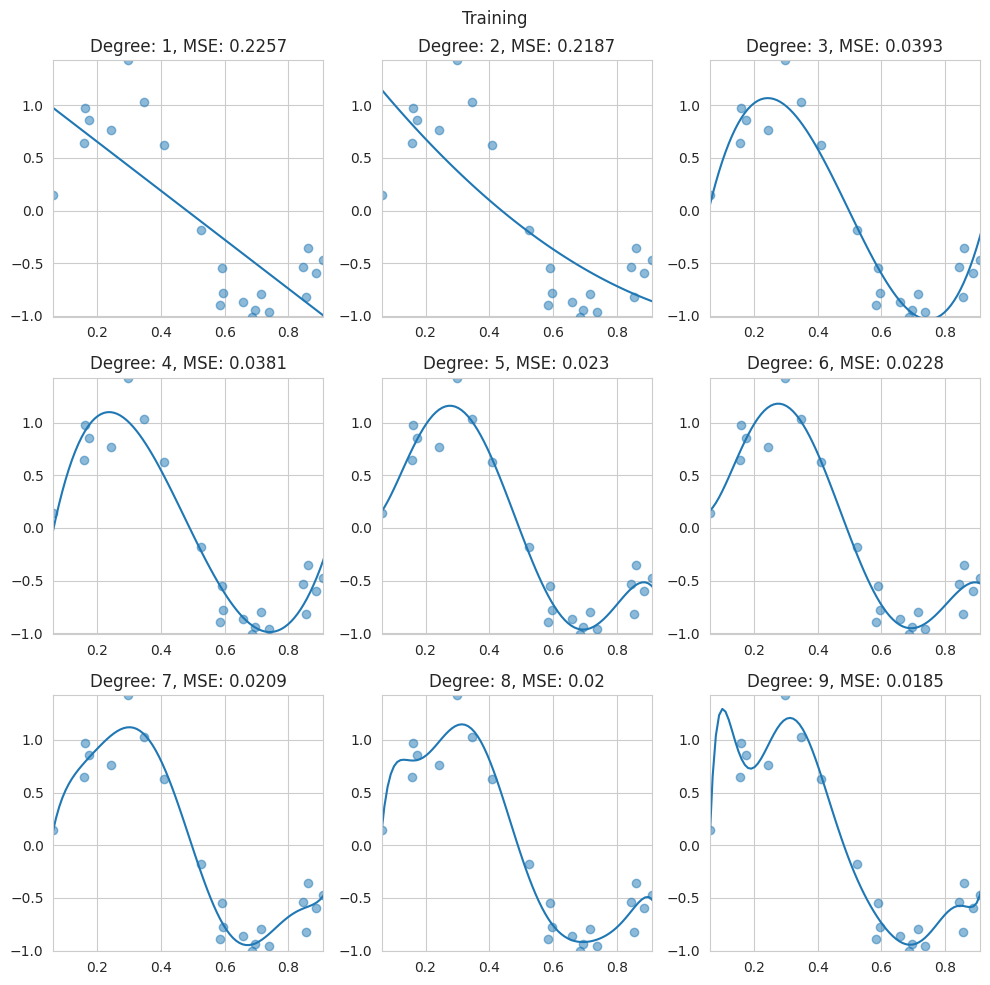

In [53]:
plt.figure(figsize=(10,10))
plt.suptitle("Training")
for i in range(1,10):
    plt.subplot(3,3,i)
    model = get_poly(i, X_train, y_train)
    plot_poly(model, X_train, y_train, i)
plt.tight_layout()

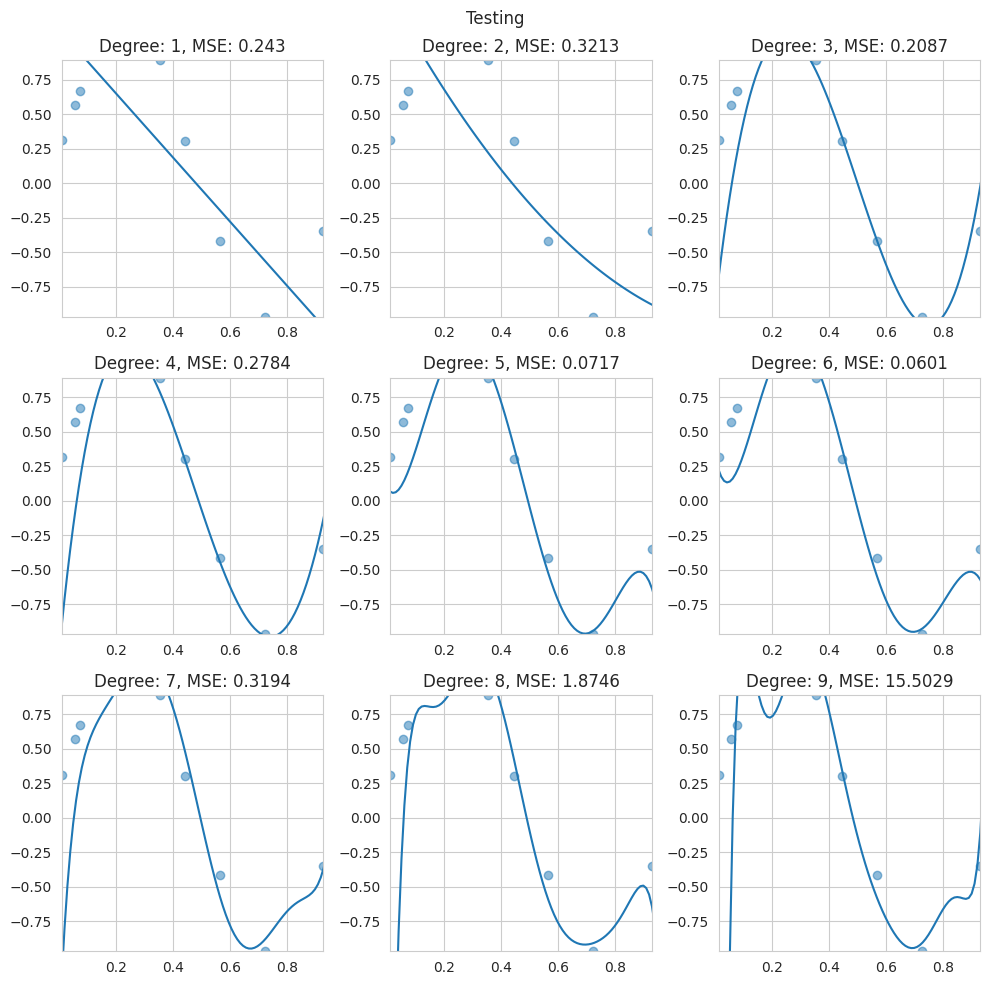

In [54]:
plt.figure(figsize=(10,10))
plt.suptitle("Testing")
for i in range(1,10):
    plt.subplot(3,3,i)
    model = get_poly(i, X_train, y_train)
    plot_poly(model, X_test, y_test, i)
plt.tight_layout()

Which dimension would you select?

The test error indicates how well the model generalizes with new data

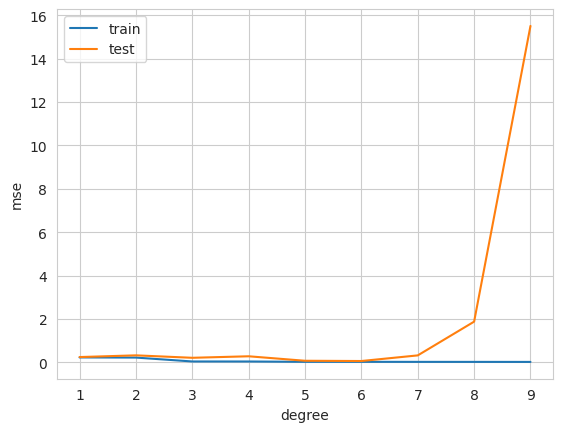

In [55]:
df = []
for i in range(1,10):
    model = get_poly(i, X_train, y_train)
    df.append({"degree": i, "train_mse": mean_squared_error(model.predict(X_train), y_train), "test_mse": mean_squared_error(model.predict(X_test), y_test)})
df = pd.json_normalize(df)
plt.plot(df["degree"], df["train_mse"], label="train")
plt.plot(df["degree"], df["test_mse"], label="test")
plt.xlabel("degree")
plt.ylabel("mse")
plt.legend()
plt.show()

The concept of Overfitting!

A function that fits excelent for a training set, but poorly on test set

Our M=20 model matches with the same values in all points in the training set, but fails dramatically in the testing set!

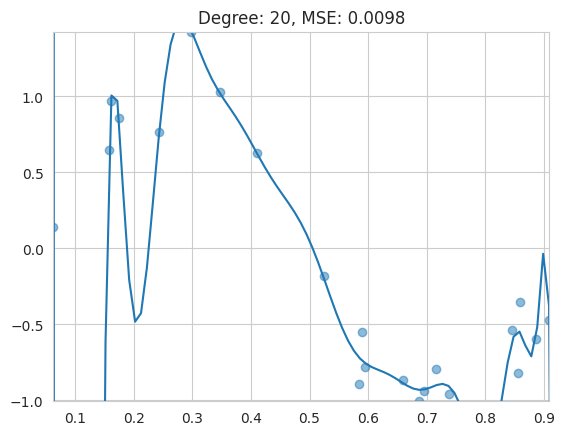

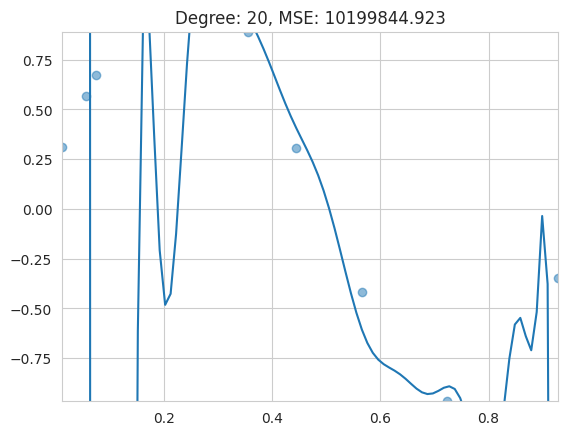

In [56]:
i = 20
model = get_poly(i, X_train, y_train)
plot_poly(model, X_train, y_train, i)
plt.show()
plot_poly(model, X_test, y_test, i)
plt.show()

Try to increase the data size and look the model behaviour

Overfitting problem becomes less severe as the size of the data set increases.

ONe technique that is often used to control over-fitting is regularization, adding a penalty term in order to discourage the coefficients from reaching large values.

THe simplest penalty is L2, the sum of squares of all the coefficients, leading to a modified error function

$$
  E(w) = \frac{1}N  \sum_j^N \{y(x_n, w) - t_n\} ^2 + \alpha ||w||^2_2
$$

Where 
$$
 ||w||^2_2 = w^T w = w_0^2 + w_1^2 + w_2^2 + ... + w_M ^2
$$

And alpha is the coefficient of importance of the regularization term.

This particular method recievew the name of shrinkage.

In [57]:
def get_poly_ridge(degree, x, y, alpha): #This function just creates a polynomial model and adjust it to the present data
    pf = PolynomialFeatures(degree=degree).fit(x) #We assign polynomial features and train using X
    lr = Ridge(alpha=alpha) #We train the linear model with order 'degree'. Ridge is just a linear regression that incorporates the regularization term L2. 
    pipe = Pipeline(
            [
                ("polynomial_features", pf),
                ("linear_regression", lr),
            ]
        )
    pipe.fit(x, y) #Let's fit and return the model
    return pipe

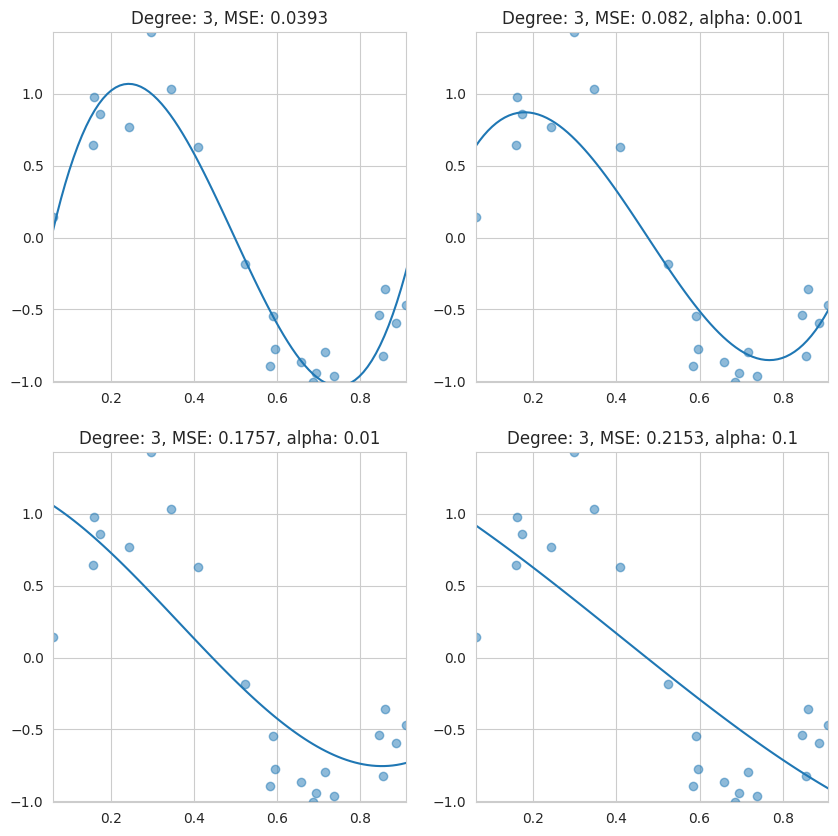

In [58]:
i = 3
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
model = get_poly(i, X_train, y_train)
plot_poly(model, X_train, y_train, i)
plt.subplot(2,2,2)
model = get_poly_ridge(i, X_train, y_train, alpha=0.001)
plot_poly(model, X_train, y_train, i, 0.001)
plt.subplot(2,2,3)
model = get_poly_ridge(i, X_train, y_train, alpha=0.01)
plot_poly(model, X_train, y_train, i, 0.01)
plt.subplot(2,2,4)
model = get_poly_ridge(i, X_train, y_train, alpha=0.1)
plot_poly(model, X_train, y_train, i, 0.1)

Let's use a cross validation method

In [59]:
pf = PolynomialFeatures(degree=3).fit(x) #We assign polynomial features and train using X
lr = Ridge(alpha=0.01) #We train the linear model with order 'degree'. Ridge is just a linear regression that incorporates the regularization term L2. 
pipe = Pipeline(
    [
        ("polynomial_features", pf),
        ("linear_regression", lr),
    ]
)
pipe
cv = cross_validate(pipe, X_train, y_train, return_estimator=True, scoring=["neg_mean_squared_error"], cv=5)
estimators = cv["estimator"]
mse = - cv["test_neg_mean_squared_error"]
print("k-fold MSE:", mse, ", mean:", mse.mean())

k-fold MSE: [0.30899688 0.0800958  0.64379764 0.53625405 0.1113528 ] , mean: 0.33609943524993346


In [60]:
print("test MSE:", np.array([mean_squared_error(y_test, a.predict(X_test)) for a in estimators]).mean())

test MSE: 0.2812084745251028


And that's all, hope you enjoyed :)